In [1]:
import pandas as pd
import numpy as np

import shap
shap.initjs()

from IPython.core.display import display, HTML

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('winequality-red.csv')

In [3]:
df.head(4)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6


In [4]:
# Посмотрим на количество дубликатов:

df.duplicated().sum()

240

In [5]:
# Удалим дубликаты:

df.drop_duplicates(inplace=True)

In [6]:
# Посмотрим на количество пропущенных значений

df.isna().sum().sum()

0

In [7]:
df.shape

(1359, 12)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1359 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1359 non-null   float64
 3   residual sugar        1359 non-null   float64
 4   chlorides             1359 non-null   float64
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   float64
 11  quality               1359 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 138.0 KB


In [9]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [10]:
df.nunique()

fixed acidity            96
volatile acidity        143
citric acid              80
residual sugar           91
chlorides               153
free sulfur dioxide      60
total sulfur dioxide    144
density                 436
pH                       89
sulphates                96
alcohol                  65
quality                   6
dtype: int64

In [11]:
df['quality'].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

Видим, что все признаки количественные, но целевой (quality) - порядковый.

Посмотрим на распределения количественных признаков:

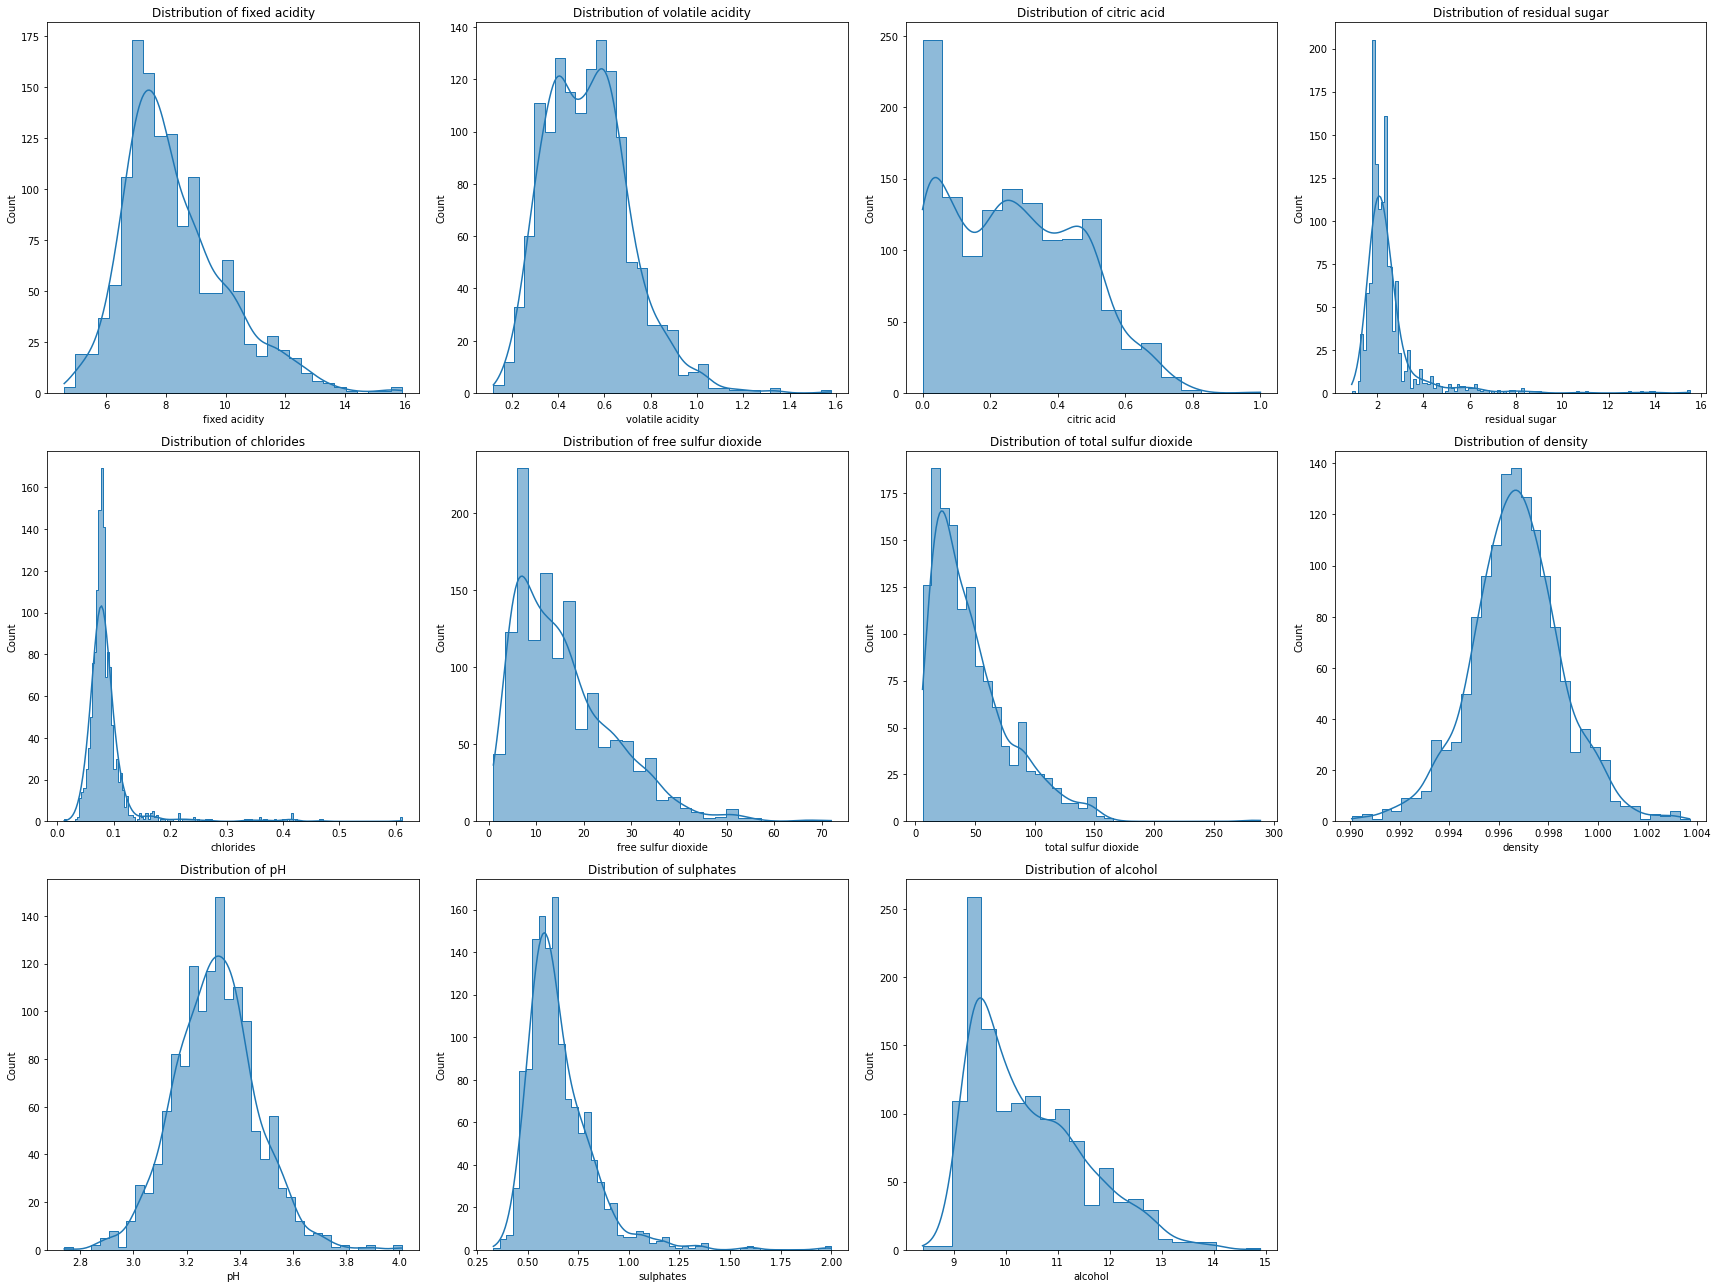

In [12]:
feature_cols=df.columns[:-1].to_numpy()
plt.figure(figsize=(24, 18))
for i, col in enumerate(feature_cols):
    plt.subplot(3, 4, i + 1)
    sns.histplot(data=df, x=col, kde=True, element='step')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

Посмотрим на распределение целевого признака:

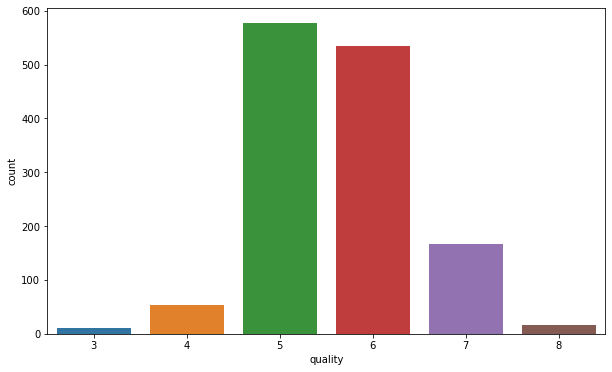

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(x='quality', data=df);

In [14]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [15]:
X.head(4)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8


In [16]:
y.head(4).to_frame()

,quality
0,5
1,5
2,5
3,6


In [17]:
estimator = RandomForestClassifier()
feature_selector = RFECV(estimator=estimator, min_features_to_select=1, step=1)
X_ = feature_selector.fit_transform(X.values, y);

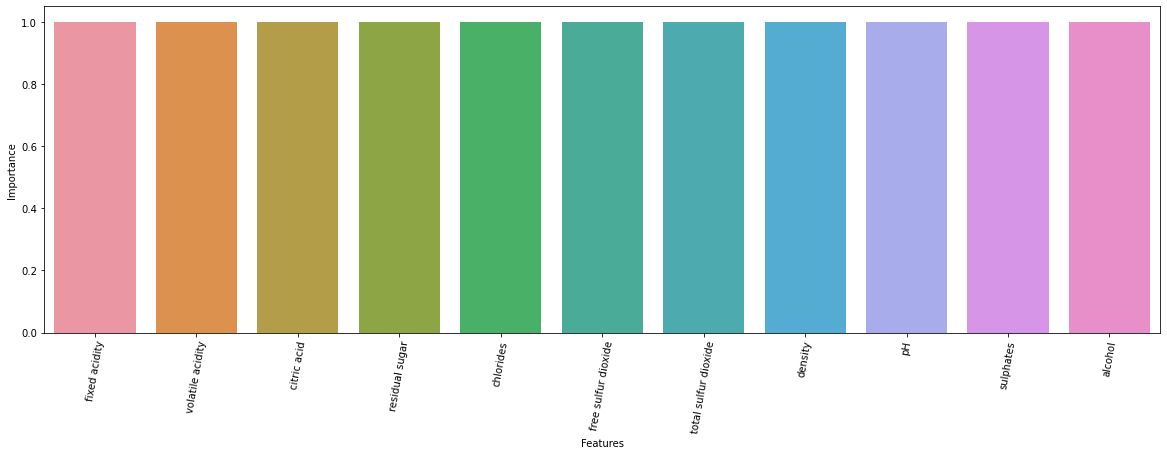

In [18]:
plot_df = pd.DataFrame({'Features': feature_cols,'Importance': feature_selector.support_.astype('int')}).sort_values('Importance', ascending=False)
plt.figure(figsize=(20, 6))
sns.barplot(x='Features', y='Importance', data=plot_df);
plt.xticks(rotation=80);

Хорошие признаки: volatile acidity, total sulfur dioxide, density, sulphates, alcohol.

In [19]:
important_columns = ['volatile acidity', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol', 'quality']
df = df[important_columns]
inputs  = df.drop(columns=['quality'])
outputs = df['quality']
inputs.shape, outputs.shape

((1359, 5), (1359,))

In [20]:
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.25, random_state=41)

In [21]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(x_train, y_train);

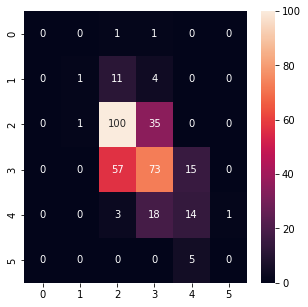

In [22]:
pred = rfc.predict(x_test)
plt.figure(figsize=(5, 5))
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt='.3g');

In [23]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.50      0.06      0.11        16
           5       0.58      0.74      0.65       136
           6       0.56      0.50      0.53       145
           7       0.41      0.39      0.40        36
           8       0.00      0.00      0.00         5

    accuracy                           0.55       340
   macro avg       0.34      0.28      0.28       340
weighted avg       0.54      0.55      0.53       340



In [24]:
print(f'Accuracy Score = {round(accuracy_score(y_test, pred) * 100, 2)}%')

Accuracy Score = 55.29%


In [25]:
print(f'F1 Score = {round(f1_score(y_test, pred, average="weighted") * 100, 2)}%')

F1 Score = 53.29%


In [26]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(x_train)

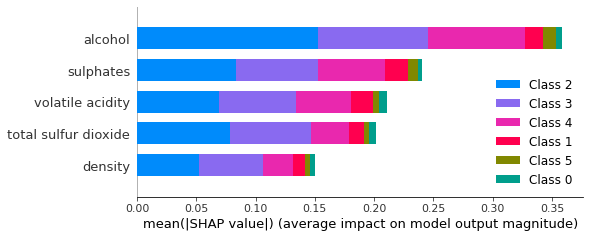

In [27]:
shap.summary_plot(shap_values, x_train)

Наиболее важный признак: alcohol.

Признаки total sulfur dioxide и violatile acidity примерно одинаковые, и можно отметить, что признак total sulfur dioxide сильнее влияет на попадание во 2 класс, чем violatile acidity, и наоборот, признак violatile acidity сильнее влияет на попадание в 4 класс, чем total sulfur dioxide.

In [28]:
def f_plot(cl):
    return shap.force_plot(explainer.expected_value[cl], shap_values[cl], x_train)

In [29]:
f_plot(0)

In [30]:
f_plot(1)

In [31]:
f_plot(2)

In [32]:
f_plot(3)

In [33]:
f_plot(4)

In [34]:
f_plot(5)